# Pkg

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from tqdm.notebook import tqdm as tqdm
import glob
import skimage.io

import cv2
import celluloid as cell
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import math

# Generating data

## tested params

In [ ]:
## THIS IS THE CURRENT SET OF PARAMS TESTED ##

# [[x = range(3)]]
# [[y = int((x+4)/3 * 2)]]

# [[z = range(3)]]
# [[zz = (z+4)/3 * 0.77]]

# set hand kinesin
# {
#     binding_rate = 10 % #/sec
#     binding_range = 0.1 % max distance from which can bind
#     bind_also_end = 1

#     unbinding_rate = [[zz]]
#     unbinding_force = 3

#     activity = move
#     unloaded_speed = [[y]] % 800 nm/s, for K401 \approx 400-500 nm/s
#                          % more velocity than speed
#     stall_force = 6

#     display = (
#         size=8;
#         color=blue;
#         width=7;
#     )
# }


In [382]:
%%bash
python3 preconfig.py test_template.cym.tpl
ls *0*.cym

4 files generated: test_template0000.cym ... test_template0003.cym
test_template0000.cym
test_template0001.cym
test_template0002.cym
test_template0003.cym


In [383]:
%%bash
python3 go_sim.py test_template0*.cym

Completed run `test_template0000.cym` in run0000
Completed run `test_template0001.cym` in run0001
Completed run `test_template0002.cym` in run0002
Completed run `test_template0003.cym` in run0003


In [385]:
%%bash
python3 scan.py '../play movie period=1 size=256 label={}' run*
python3 make_page.py run*

generated 'page.html' with 4 entries


-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  /Users/cathji/Documents/GitHub/am_atp/analysis/cytosim/run0000
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  /Users/cathji/Documents/GitHub/am_atp/analysis/cytosim/run0001
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  /Users/cathji/Documents/GitHub/am_atp/analysis/cytosim/run0002
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  /Users/cathji/Documents/GitHub/am_atp/analysis/cytosim/run0003


# Data pipeline

## txt files

In [392]:
base_string = '000'
folder_list = glob.glob('run' + base_string + '*/')

text_files = [f + 'report.txt' for f in folder_list]

In [393]:
df = pd.read_csv(text_files[0],
                 sep="\n",
                 header=None)
rows = len(df.index)

## helper fxns

In [396]:
def make_hists(bin_num, pos_x, pos_y, im_nums):

    fig, ax = plt.subplots(dpi = 300)
    # hists = np.zeros(range(np.shape(pos_x)[0]), )

    ind = 0
    temp_pos_x = pos_x[ind]
    temp_pos_y = pos_y[ind]
    hist, xbins, ybins, im = ax.hist2d(temp_pos_x, temp_pos_y, bins = bin_num)

    hists = np.zeros((im_nums, len(xbins)-1,len(ybins)-1))

    for i in tqdm(range(im_nums)):
        ind = i
        temp_pos_x = pos_x[ind]
        temp_pos_y = pos_y[ind]

        hist, xbins, ybins, im = ax.hist2d(temp_pos_x, temp_pos_y, bins = bin_num);
        ax.set_aspect('equal', 'box')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


    #     fig.savefig('./heatmaps/heatmap' + str(i) + '.tiff', bbox_inches = 'tight')
        hists[i,:,:] = hist
        plt.close(fig)
    
    return hists

In [397]:
def read_result(file_name):
    data = []
    time = []
    count = 0
    
    df = pd.read_csv(file_name,
                 sep="\n",
                 header=None)
    rows = len(df.index)
    
    with open(file_name) as fp:

        new_data = False
        temp_data = []

        for x in range(rows):
            count += 1
            line = fp.readline()[:-1]
            lst = line.split(" ")
            lst = [val for val in lst if val != '' and val != '%']

            if len(lst) == 10:
                temp_data.append(lst)

            if lst and lst[0] == 'time':
                time.append(lst[1])

            if lst and lst[0] == 'end':
                if temp_data[1:]:
                    data.append(temp_data[1:])
                else:
                    time = time[:-1]
                temp_data = []

    data = np.array(data, dtype = 'float')
    return data

In [417]:
def find_centers(im_nums, hists):
    centers_tc = []
    radii = []
    frame_num = []
    contours_plot = []

    area_thresh = 1
    past_center = None
    areas = []

    #for loop thru MT images
    for i in tqdm(range(im_nums)):
        #crop image for center identification

        im = hists[i,:,:]

        #gaussian blur
        dst = im
        thresh = np.percentile(dst, 50)

        binary = (dst>thresh).astype(np.uint8)

        #create a contour
        contours, hierarchy = cv2.findContours(binary, 1, 2)

        #iterate through contours (for most connected region)
        max_area = 0
        max_index = None

        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                max_index = j

        if max_area >= area_thresh:
            cnt = contours[max_index]
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            centers_tc.append([x, y])
            radii.append(radius)
            frame_num.append(i)

            cnt = np.array(cnt)
            cnt = np.squeeze(cnt)
            contours_plot.append(cnt)

        else:
            print("**CENTER NOT FOUND**")
            cnt = contours[max_index]
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            centers_tc.append([x, y])
            radii.append(radius)

            cnt = np.array(cnt)
            cnt = np.squeeze(cnt)
            contours_plot.append(cnt)

        areas.append(max_area)

    centers_tc = np.array(centers_tc)
    radii = np.array(radii)
    frame_num = np.array(frame_num)
    areas = np.array(areas)
    
    return centers_tc, radii, frame_num, areas

In [ ]:
# for t in range(len(time)):
#     temp = ilid_micro2[t,:,:]
#     temp = temp[temp[:,1].argsort()]
#     ilid_micro2[t,:,:] = temp

## Run

In [428]:
# temp_data = read_result(text_files[0])
temp_pos_x = temp_data[:,:,3]
temp_pos_y = temp_data[:,:,4]

row_num = np.shape(temp_pos_x)[0]
temp_bin_numb = 60

temp_hists = make_hists(temp_bin_numb, temp_pos_x, temp_pos_y, row_num)
temp_centers, temp_radii, temp_frame_num, temp_areas = find_centers(row_num, temp_hists)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [402]:
temp1_data = read_result(text_files[1])
temp1_pos_x = temp1_data[:,:,3]
temp1_pos_y = temp1_data[:,:,4]

row_num = np.shape(pos_x)[0]
temp1_bin_numb = 60

temp1_hists = make_hists(temp1_bin_numb, temp1_pos_x, temp1_pos_y, row_num)
temp1_centers, temp1_radii, temp1_frame_num, temp1_areas = find_centers(row_num, temp1_hists)

700500


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [430]:
def data_stack(list_of_files):

    frames = []
    centers = []
    radii = []
    areas = []
    hists_final = []
    data_final = []
    
    for i in range(len(list_of_files)):
        temp_data = read_result(list_of_files[i])
        
        temp_pos_x = temp_data[:,:,3]
        temp_pos_y = temp_data[:,:,4]

        row_num = np.shape(temp_data)[0]
        temp_hists = make_hists(temp_bin_numb, temp_pos_x, temp_pos_y, row_num)
        temp_centers, temp_radii, temp_frame_num, temp_areas = find_centers(row_num, temp_hists)
        
        centers.append(temp_centers)
        radii.append(temp_radii)
        frames.append(temp_frame_num)
        areas.append(temp_areas)
        hists_final.append(temp_hists)
        data_final.append(temp_data)

    final_centers = np.stack(centers)
    final_radii = np.stack(radii)
    final_frames = np.stack(frames)
    final_areas = np.stack(areas)
    final_hists = np.stack(hists_final)
    final_data = np.stack(data_final)
    
    return final_centers, final_radii, final_frames, final_areas, final_hists, final_data
        

In [431]:
text_files = np.sort(text_files)
c, r, f, a, h, d = data_stack(text_files)

700500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

700500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

700500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

700500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

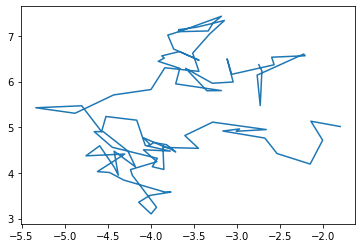

In [447]:
# aster
# frame
# microtubule
# params

np.shape(d)

xx = d[2,:,10,3]
yy = d[2,:,10,4]

plt.plot(xx,yy)

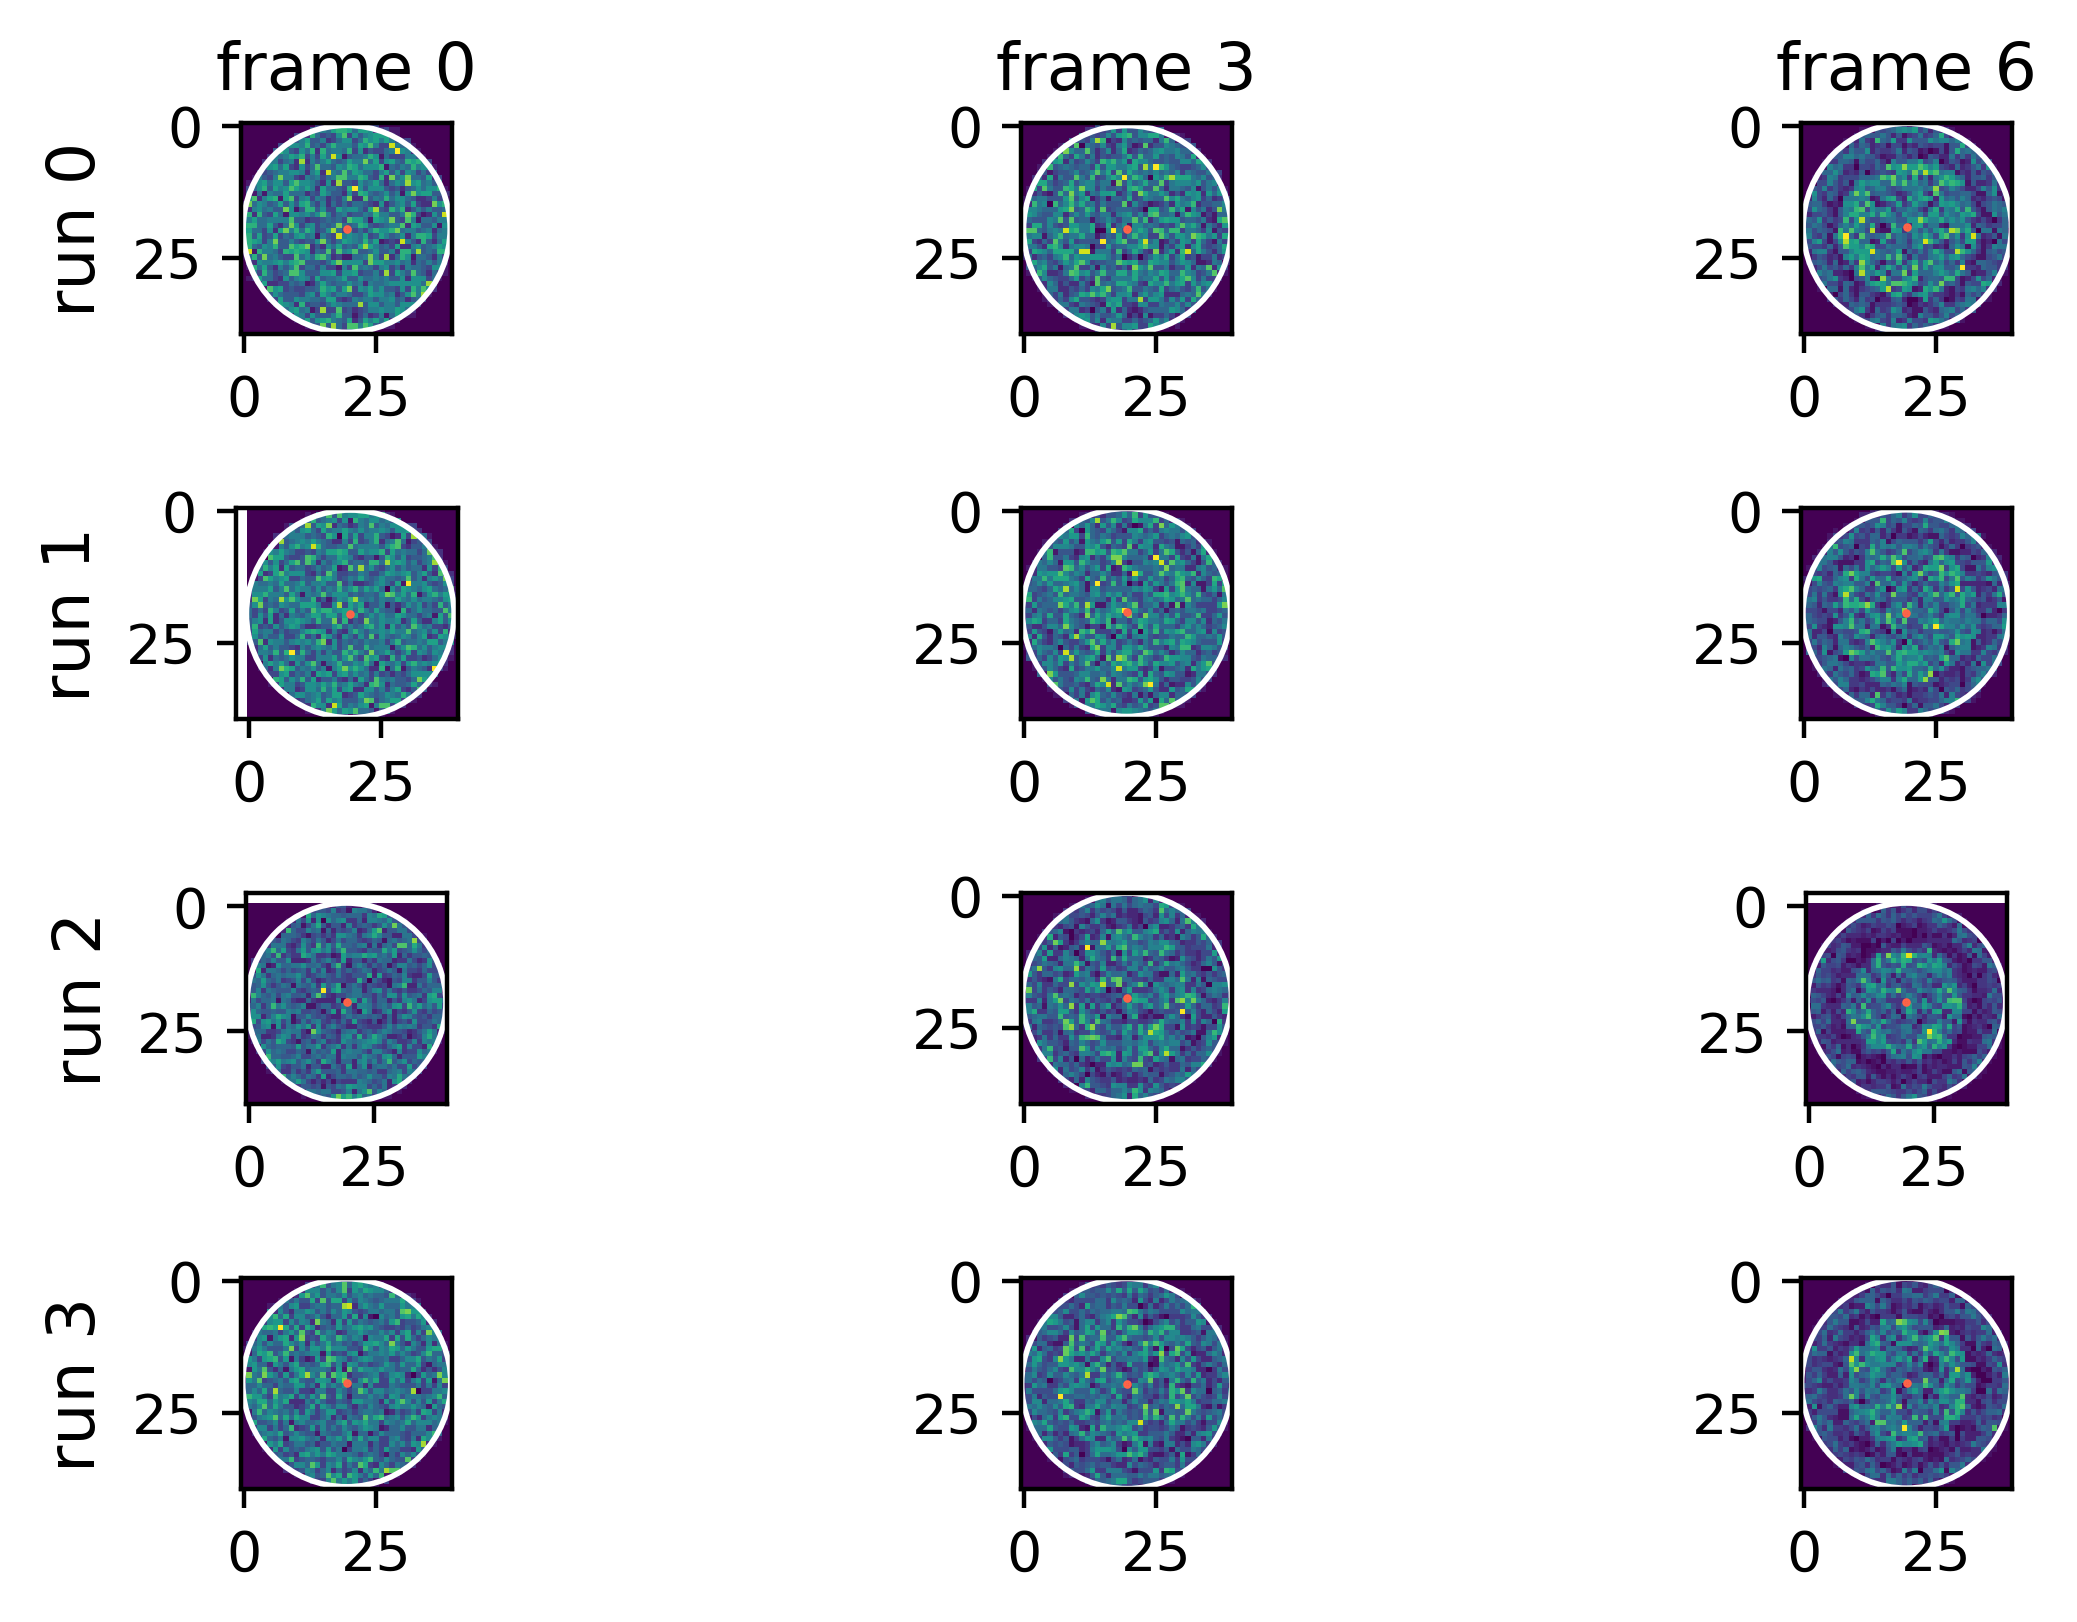

In [421]:
num_files = len(text_files)
num_steps = 3

param = a

fig, ax = plt.subplots(
    num_files,
    num_steps,
    dpi=400,
)
fig.tight_layout()

for i in range(num_files):
    for j in range(num_steps):
        ax_temp = ax[i, j]
        c_temp = c[i,j]
        r_temp = r[i,j]
        
        if (j == 0):
            ax_temp.set_ylabel('run ' + str(i), size='large')

        temp_frame_num = math.floor(row_num / num_steps * j)

        if (i == 0):
            ax_temp.set_title('frame ' + str(temp_frame_num), size='large')

        ax_temp.set_aspect('equal', 'box')
        ax_temp.imshow(h[i, temp_frame_num, :, :], zorder = 0)
        
        ax_temp.scatter(c_temp[0], c_temp[1], color='tomato', s=0.3)
        circle1 = plt.Circle((c_temp[0], c_temp[1]),
                             r_temp,
                             fill=False,
                             color='w')
        ax_temp.add_patch(circle1)


In [425]:
#plotting params

num_files = len(text_files)
num_steps = 3
height = 2
width = 2

labels_base_x = "Unbinding rate (" + r"$\frac{1}{s}$" + "): "
labels_base_y = "Motor Speed (" + r"$\frac{\mu m}{s}$" + "): "

labels_vals_x = [0.38, 0.77]
labels_vals_y = [1, 2]

In [426]:
num_frames = np.shape(h)[1]

  0%|          | 0/99 [00:00<?, ?it/s]

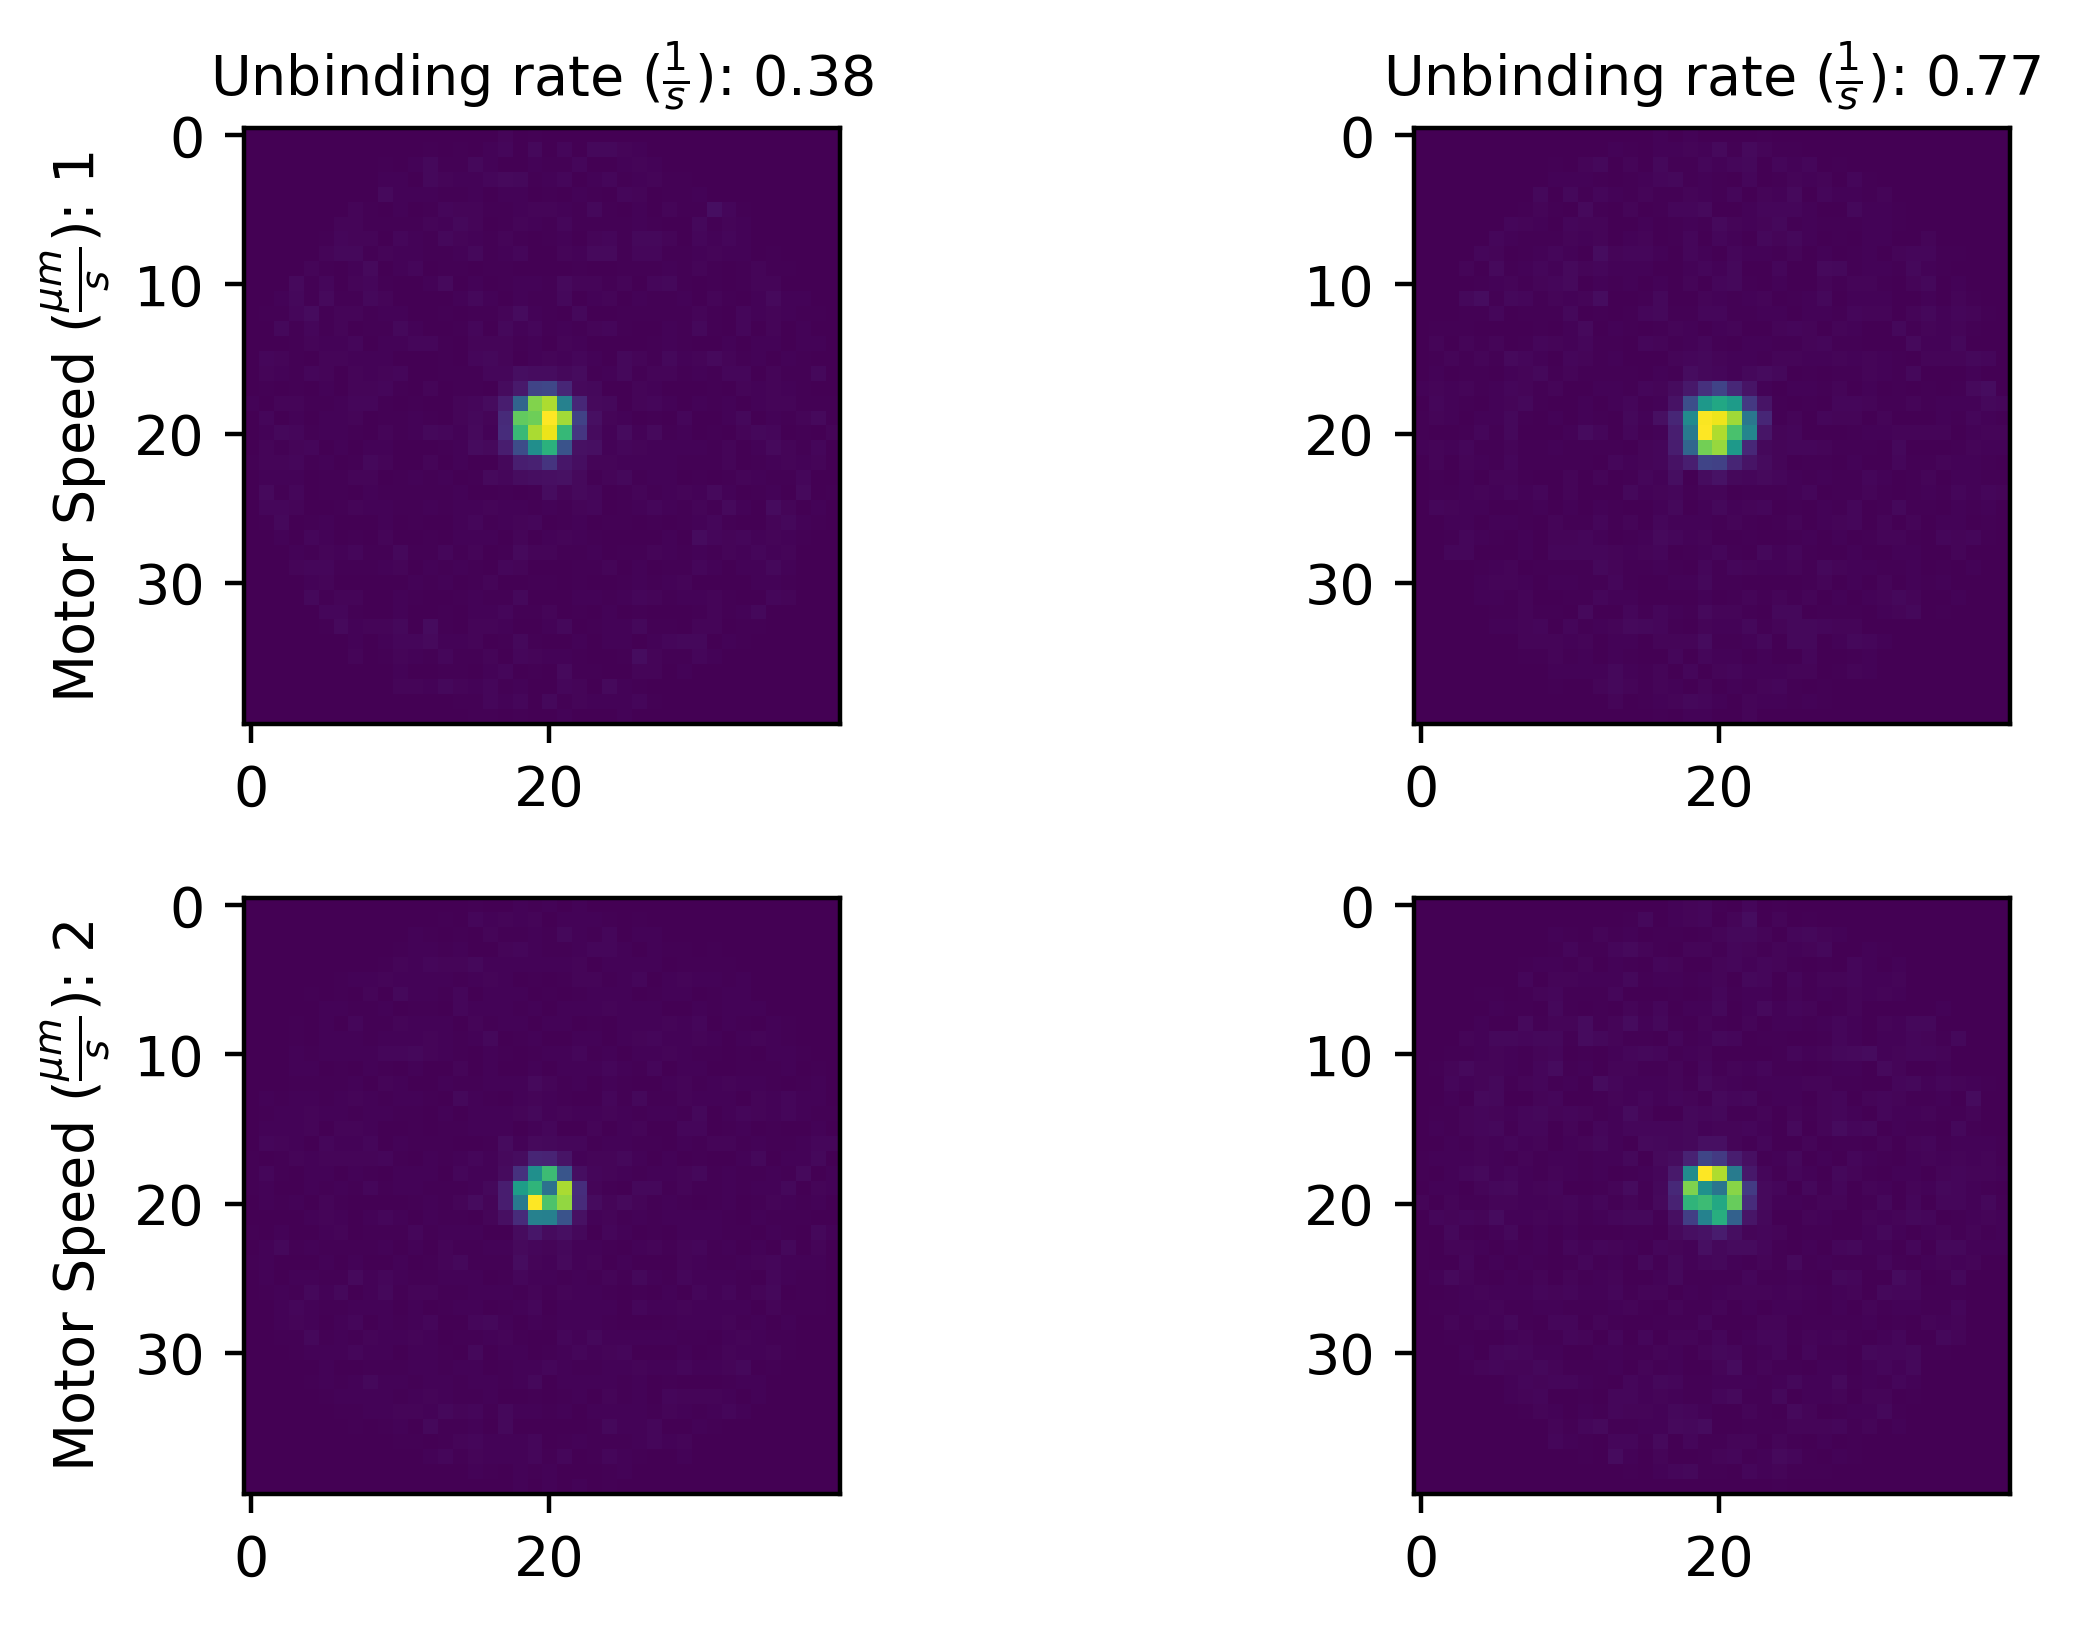

In [427]:
#animating

fig, ax = plt.subplots(
    height,
    width,
    dpi=400,
)
fig.tight_layout()
camera = cell.Camera(fig)

for j in tqdm(range(num_frames)):
    for i in range(num_files): 
        col = (i%height)
        row = math.floor((i - (i%width))/height)

        ax_temp = ax[row, col]

        if (row == 0):
            ax_temp.set_title(labels_base_x + str(labels_vals_x[col]), fontsize=10)

        if (col == 0):
            ax_temp.set_ylabel(labels_base_y + str(labels_vals_y[row]), fontsize=10)

        ax_temp.set_aspect('equal', 'box')
        ax_temp.imshow(h[i, j, :, :])
    
    camera.snap()

animation = camera.animate()
# tqdm(animation.save("movie_contraction.mp4"))

# Agent based

In [ ]:
plt.scatter(h[0,])

# Plotting parameters

  0%|          | 0/99 [00:00<?, ?it/s]

0it [00:00, ?it/s]

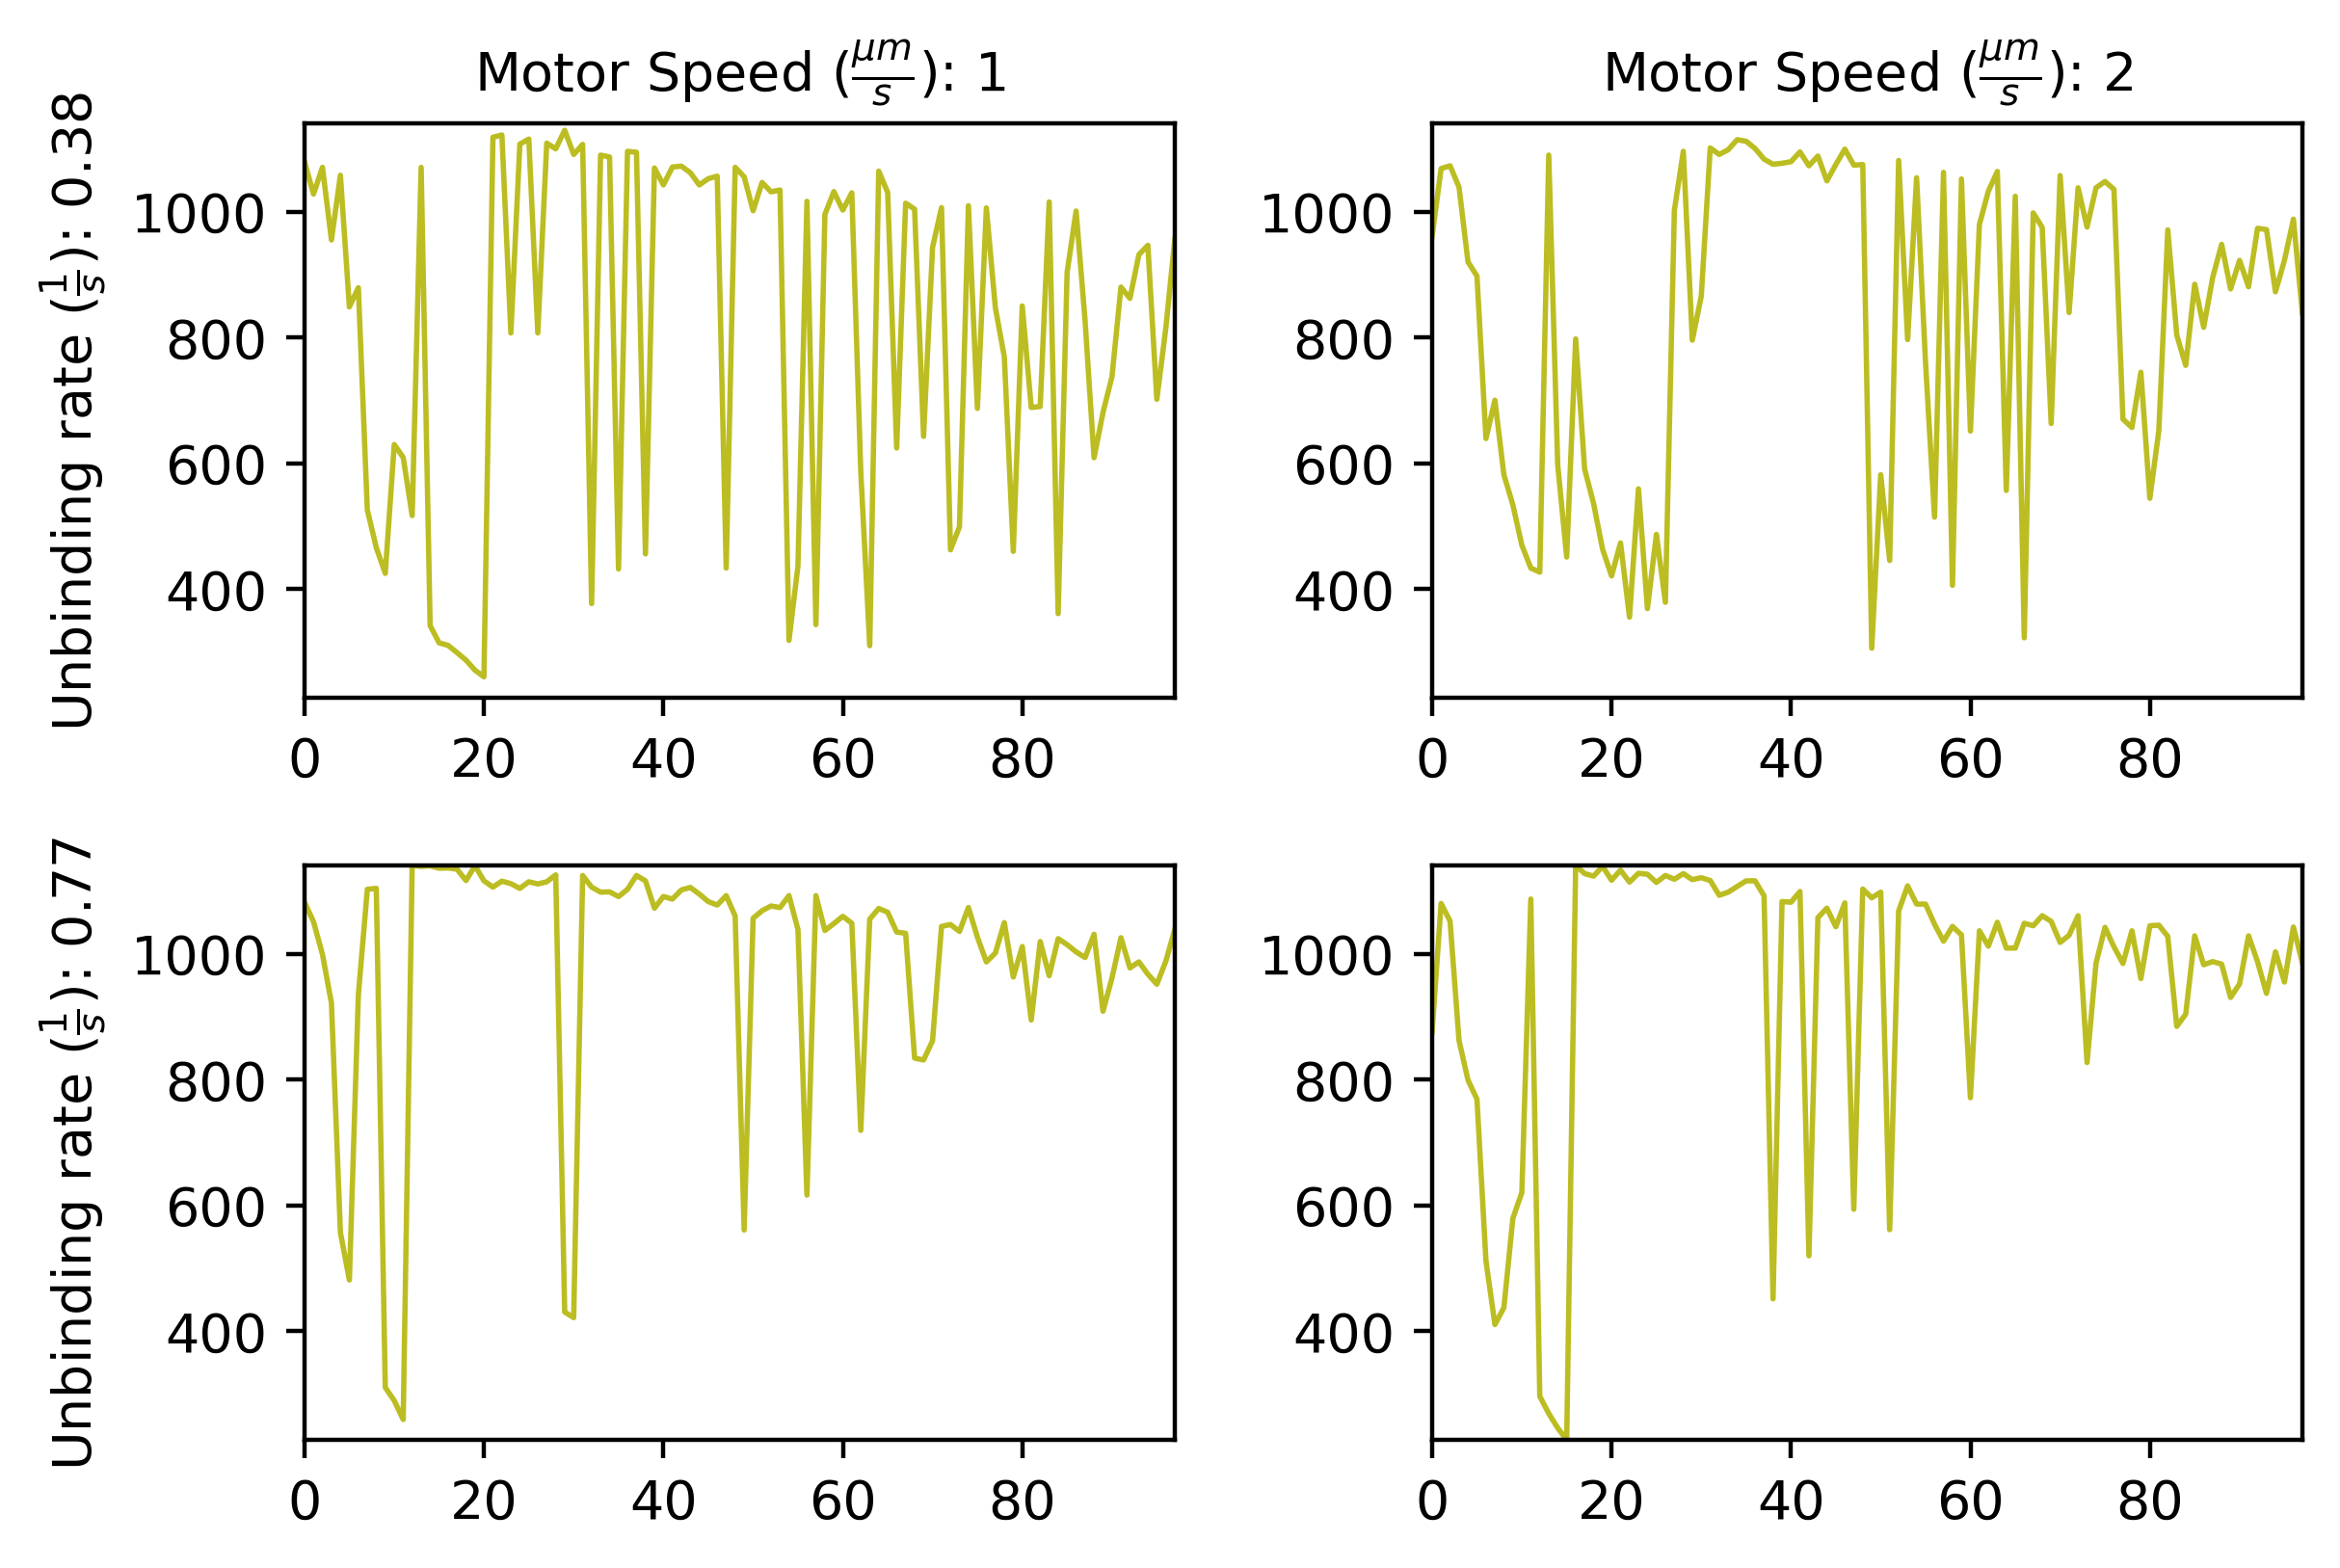

In [429]:
param_of_interest = a

#plotting params

num_files = len(text_files)
num_steps = 3
height = 2
width = 2

labels_vals_x = [0.38, 0.77]
labels_vals_y = [1, 2]

xlim_min = 0
xlim_max = np.shape(param_of_interest[0])[0] - 2

ylim_min = np.min(param_of_interest)
ylim_max = np.max(param_of_interest)

#animating

fig, ax = plt.subplots(
    height,
    width,
    dpi=400,
)
fig.tight_layout()
camera = cell.Camera(fig)

for j in tqdm(range(num_frames)):
    for i in range(num_files): 
        col = (i%height)
        row = math.floor((i - (i%width))/height)

        param_array = None
        num_indices = 2
        
        if (num_indices == 2):
            param_array = param_of_interest[i,:j]
            
        ax_temp = ax[row, col]

        if (row == 0):
            ax_temp.set_title(labels_base_y + str(labels_vals_y[col]), fontsize=10)

        if (col == 0):
            ax_temp.set_ylabel(labels_base_x + str(labels_vals_x[row]), fontsize=10)

        ax_temp.set_xlim(xlim_min, xlim_max)
        ax_temp.set_ylim(ylim_min, ylim_max)
        ax_temp.plot(param_array, linewidth = 1)
    
    camera.snap()

animation = camera.animate()
tqdm(animation.save("movie_2.mp4"))

# Phase space

# Radial traces

In [ ]:
def profile_fn(im,
               r_min=2.5,
               dr=1.5,
               r_max=None,
               avg_method='mean',
               n_positions=100,
               n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    # Dimensions of the image
    H, W = im.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if type(r_max) != np.ndarray:
        r_max = 0.5 * np.min([H, W]) - 0.5

    r_unif_ls = np.linspace(r_min, r_max, n_positions)

    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
        angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk > angle_bins[k])
                          & (angle_disk <= angle_bins[k + 1])]
            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)

    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.median(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.mean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_mat,
        "angles": angles,
        "r_ls": r_ls,
        "im_ls": im_ls
    }

    return profile_output

# Commands to remove files

In [380]:
%%bash
rm -r run0*/

rm: run0*/: No such file or directory


CalledProcessError: Command 'b'rm -r run0*/\n'' returned non-zero exit status 1.

In [381]:
%%bash
rm -r *template0*.cym

rm: *template0*.cym: No such file or directory


CalledProcessError: Command 'b'rm -r *template0*.cym\n'' returned non-zero exit status 1.